# Logistic and linear regression with deterministic and stochastic first order methods

    TP 3 : Optimisation - DataScience Master
    Authors : Stéphane Gaiffas, Alexandre Gramfort
   
The aim of this TP is to implement and compare various batch and stochastic algorithms for linear and logistic with ridge penalization. 
The following methods are compared in this notebook.

**Batch (deterministic) methods**
- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS
- conjugate gradient (CG)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 27th of november at 23:55**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a section called **2016/11/21 Practical session **. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes

We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(x_i^\top \theta, y_i) + \frac \lambda 2 \|\theta\|_2^2
$$
where
- $\ell(z, y) = \frac 12 (y - z)^2$ (least-squares regression)
- $\ell(z, y) = \log(1 + \exp(-yz))$ (logistic regression).

We write it as a a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(\theta)
$$
where
$$
f_i(\theta) = \ell(x_i^\top \theta, y_i) + \frac \lambda 2 \|\theta\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(\theta) = (x_i^\top \theta - y_i) x_i + \lambda \theta
$$
and
$$
\nabla f_i(\theta) = - \frac{y_i}{1 + \exp(y_i x_i^\top \theta)} x_i + \lambda \theta.
$$

Denote by $L$ the Lipschitz constant of $f$ and by $L_i$ the Lipschitz constant of $f_i$. 
One can see easily that for linear regression
$$
L = \frac{ \|\mathbf X^\top \mathbf X \|_{\text{op}}}{n} + \lambda \quad \text{ and } L_i = \| x_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf X^\top \mathbf X \|_{\text{op}}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| x_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / \max_{i=1,\ldots,n} L_i$

We now introduce a class that will be used for the solvers.

In [3]:
from scipy.linalg import svd

class LinReg(object):
    """A class for the least-squares regression with
    Ridge penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda
    
    def grad(self, x):
        return self.A.T.dot(self.A.dot(x) - self.b) / self.n + self.lbda * x

    def loss(self, x):
        return norm(self.A.dot(x) - self.b) ** 2 / (2. * self.n) + self.lbda * norm(x) ** 2 / 2.
    
    def grad_i(self, i, x):
        a_i = self.A[i]
        return (a_i.dot(x) - self.b[i]) * a_i + self.lbda * x

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        L = np.max(svd(self.A, full_matrices=False)[1]) ** 2 / self.n + self.lbda
        return L

In [4]:
class LogReg(object):
    """A class for the logistic regression with L2 penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda
    
    def grad(self, x):
        bAx = self.b * np.dot(self.A, x)
        temp = 1. / (1. + np.exp(bAx))
        grad = - np.dot(self.A.T, self.b * temp) / self.n + self.lbda * x
        return grad

    def loss(self, x):
        bAx = self.b * np.dot(self.A, x)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(x) ** 2 / 2.
    
    def grad_i(self, i, x):
        grad = - self.A[i] * self.b[i] / (1. + np.exp(self.b[i] * np.dot(self.A[i], x)))
        grad += self.lbda * x
        return grad

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        L = np.sum(np.max(self.A ** 2, axis=1)) / (4. * self.n) + self.lbda
        return L

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [5]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz

    
def simu_linreg(x, n, std=1., corr=0.5):
    """
    Simulation of the least-squares problem
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """    
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x_truth) + noise
    return A, b

In [6]:
def simu_logreg(x, n, std=1., corr=0.5):
    """
    Simulation of the logistic regression problem
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """    
    A, b = simu_linreg(x, n, std=1., corr=0.5)
    return A, np.sign(b)

In [7]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_truth = (-1) ** (idx - 1) * np.exp(-idx / 10.)

A, b = simu_linreg(x_truth, n, std=1., corr=0.2)

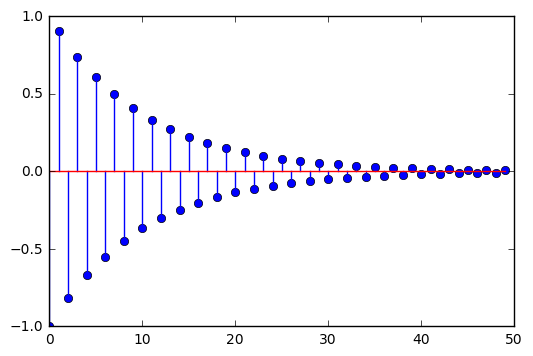

In [8]:
plt.stem(x_truth);

### Numerically check loss and gradient

In [9]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)
A, b = simu_linreg(x_truth, n, std=1., corr=0.2)
model = LinReg(A, b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

1.4971519630041453e-06

In [10]:
lbda = 1. / n ** (0.5)
A, b = simu_logreg(x_truth, n, std=1., corr=0.2)
model = LogReg(A, b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

1.5159168153402114e-07

### Choice of the model

In [104]:
#Linreg
A, b = simu_linreg(x_truth, n, std=1., corr=0.5)
model = LinReg(A, b, lbda)

#Logreg
# A, b = simu_logreg(x_truth, n, std=1., corr=0.2)
# model = LogReg(A, b, lbda)

### Compute the theoretical step-size for FISTA

In [105]:
from scipy.linalg import svd

step = 1. / model.lipschitz_constant()

print("step = %s" % step)

step = 0.326781224728


### Get a very precise minimum to compute distances to minimum

In [106]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
print(f_min)

0.5084580345959153


<a id='batch'></a> 

## 3. Deterministic methods (ISTA, FISTA, BGFS)

Before implementing the logic of GD, ISTA or FISTA we provide a simple function to be called after each iteration to gather and display a few metrics about current the minimization process.

In [107]:
def inspector(loss_fun, x_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(xk):
        obj = loss_fun(xk) - f_min
        err = norm(xk - x_min)
        objectives.append(obj)
        errors.append(err)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    return inspector_cl

In [108]:
# Number of iterations
n_iter = 50

### ISTA

We recall that an iteration of ISTA (actually a batch gradient here) writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the Ista solver in the cell below

In [109]:
def ista(x_init, grad, n_iter=100, step=1., callback=None):
    """ISTA algorithm."""
    x = x_init.copy()
    
    for i in range(n_iter):
        
        ### TODO
        x -= step*grad(x)
        ### END TODO

        # Update metrics after each iteration.
        if callback: 
            callback(x)

    return x

In [110]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
ista_inspector = inspector(model.loss, x_truth, verbose=True)
x_ista = ista(x_init, model.grad, n_iter, step, callback=ista_inspector)

   it    |   obj    |   err   
       0 | 7.44e-01 | 2.00e+00
      10 | 5.80e-02 | 5.72e-01
      20 | 4.97e-03 | 1.68e-01
      30 | 4.35e-04 | 4.99e-02
      40 | 3.86e-05 | 1.49e-02


### FISTA

We recall that an iteration of FISTA (actually an accelerated batch gradient here) writes

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the Fista solver in the cell below

In [111]:
def fista(x_init, grad, n_iter=100, step=1., callback=None):
    """FISTA algorithm."""
    x = x_init.copy()
    x_old = x_init.copy()
    y = x_init.copy()
    t = 1.

    for i in range(n_iter):
        
        ### TODO
        x_old = x
        x = y - step*grad(y)
        t_old = t
        t = (1 + np.sqrt(1 + 4*t**2))/2
        y = x + ((t_old - 1)/t) * (x - x_old)
        ### END TODO

        # Update metrics after each iteration.
        if callback: 
            callback(x)
    return x

In [112]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
fista_inspector = inspector(model.loss, x_truth, verbose=True)
x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)

   it    |   obj    |   err   
       0 | 7.44e-01 | 2.00e+00
      10 | 1.00e-03 | 7.24e-02
      20 | 1.41e-04 | 2.79e-02
      30 | 2.51e-05 | 1.19e-02
      40 | 4.56e-06 | 5.08e-03


### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s conjuguate gradient solver.

In [113]:
# Conjugate gradient descent
from scipy.optimize import fmin_cg

x_init = np.zeros(d)
cg_inspector = inspector(model.loss, x_truth, verbose=True)
x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector)

   it    |   obj    |   err   
       0 | 4.18e-01 | 1.45e+00
      10 | 1.80e-06 | 1.89e-03
Optimization terminated successfully.
         Current function value: 0.508458
         Iterations: 19
         Function evaluations: 30
         Gradient evaluations: 30


### scipy.optimize's BFGS

Let's compare with ``scipy.optimize``'s BFGS solver

In [114]:
# Conjugate gradient descent
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
bfgs_inspector = inspector(model.loss, x_truth, verbose=True)
x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)

   it    |   obj    |   err   
       0 | 4.13e-01 | 1.44e+00
      10 | 5.78e-07 | 1.40e-03


### A first numerical comparison of deterministic solvers

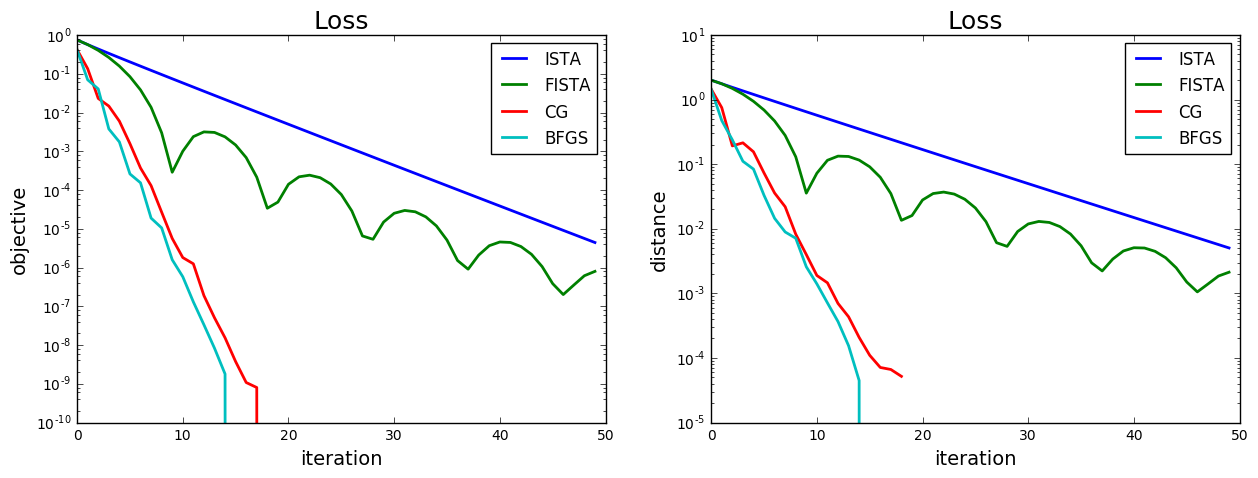

In [115]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector]

solvers = ["ISTA", "FISTA", "CG", "BFGS"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("objective", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("distance", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);

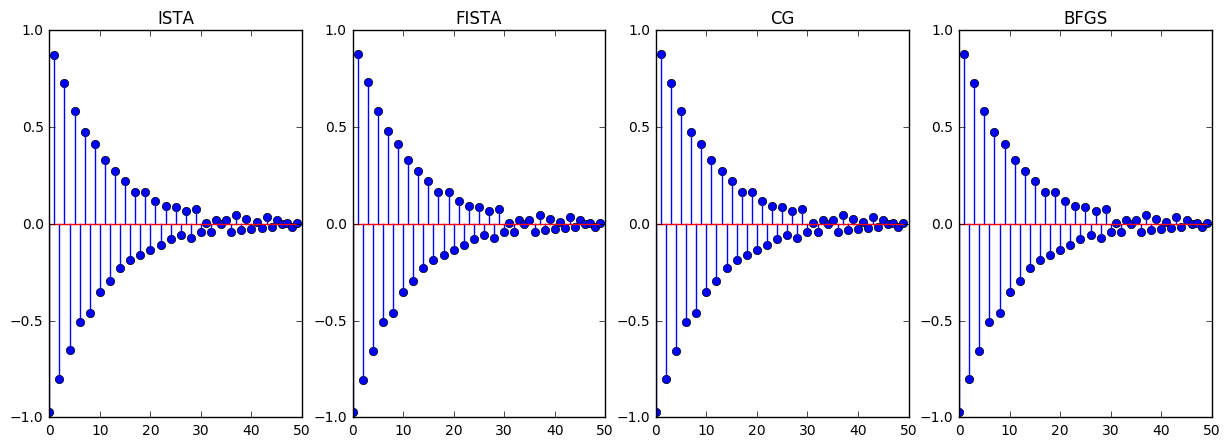

In [116]:
plt.figure(figsize=(15, 5))

xs = [x_ista, x_fista, x_cg, x_bfgs]

for i, name, x in zip(range(1, 5), solvers, xs):
    plt.subplot(1, 4, i)
    plt.stem(x)
    plt.ylim([-1, 1])
    plt.title(name)

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about Fista, is it suprising ?

- First, we observe that FISTA converges faster than ISTA (which confirms Beck Teboule theorems seen in lecture 1). However, CG and BFGS converge way faster than ISTA and FISTA, with BFGS converging a bit faster than CG (after the first iteration).

- We observe that the convergence of FISTA is not linear. Indeed, FISTA is not a descent algorithm, by construction.

<a id='stoc'></a> 
## 4. Stochastic methods

In [117]:
n_iter = 50

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)  

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [118]:
def sgd(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    
    for idx in range(n_iter):
        
        ### TODO
        i = iis[idx]
        x = x - step*grad_i(i,x)/(np.sqrt(idx+1))
        ### END TODO
        
        # Update metrics after each iteration.
        if callback and idx % n == 0:
            callback(x)
    return x

In [119]:
step0 = 0.25
x_init = np.zeros(d)
sgd_inspector = inspector(model.loss, x_truth, verbose=True)
x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=step0, callback=sgd_inspector)

   it    |   obj    |   err   
       0 | 7.56e+00 | 3.40e+00
      10 | 1.25e-02 | 1.50e-01
      20 | 6.06e-03 | 1.16e-01
      30 | 6.34e-03 | 1.24e-01
      40 | 4.30e-03 | 9.74e-02


### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [120]:
def sag(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    y = np.zeros(d)
    avg_grad = np.zeros(d)
    
    for idx in range(n_iter):
    
        ### TODO
        i = iis[idx]
        y = grad_i(i, x)
        avg_grad = avg_grad + (1./n)*(y - gradient_memory[i, :]) 
        gradient_memory[i, :] = y
        x = x - step*avg_grad
        ### END OF TODO
        
        # Update metrics after each iteration.
        if callback and idx % n == 0:
            callback(x)
    return x

In [121]:
max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))

if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda / model.n)
else:
    step = 1.0 / (max_squared_sum + model.lbda / model.n)

x_init = np.zeros(d)
sag_inspector = inspector(model.loss, x_truth, verbose=True)
x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)

   it    |   obj    |   err   
       0 | 1.02e+00 | 2.29e+00
      10 | 2.22e-02 | 1.79e-01
      20 | 2.33e-04 | 2.10e-02
      30 | 4.14e-06 | 3.10e-03
      40 | 4.30e-08 | 2.98e-04


### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [122]:
def svrg(x_init, iis, grad, grad_i, n_iter, step, callback=None):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    
    ### TODO
    for idx in range(n_iter):
        i = iis[idx]
        if idx % n == 0:
            x_old = x
            mu = grad(x)
        x = x - step*(grad_i(i,x) - grad_i(i,x_old) + mu)
    ### END TODO   
        
        # Update metrics after each iteration.
        if callback and idx % n == 0:
            callback(x)
    return x

In [123]:
#step = 1. / (20. * model.lipschitz_constant())

x_init = np.zeros(d)
svrg_inspector = inspector(model.loss, x_truth, verbose=True)    
x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n * n_iter, step, callback=svrg_inspector)

   it    |   obj    |   err   
       0 | 1.01e+00 | 2.28e+00
      10 | 2.66e-06 | 2.56e-03
      20 | -5.14e-10 | 4.84e-05
      30 | -5.43e-10 | 4.64e-05
      40 | -5.43e-10 | 4.64e-05


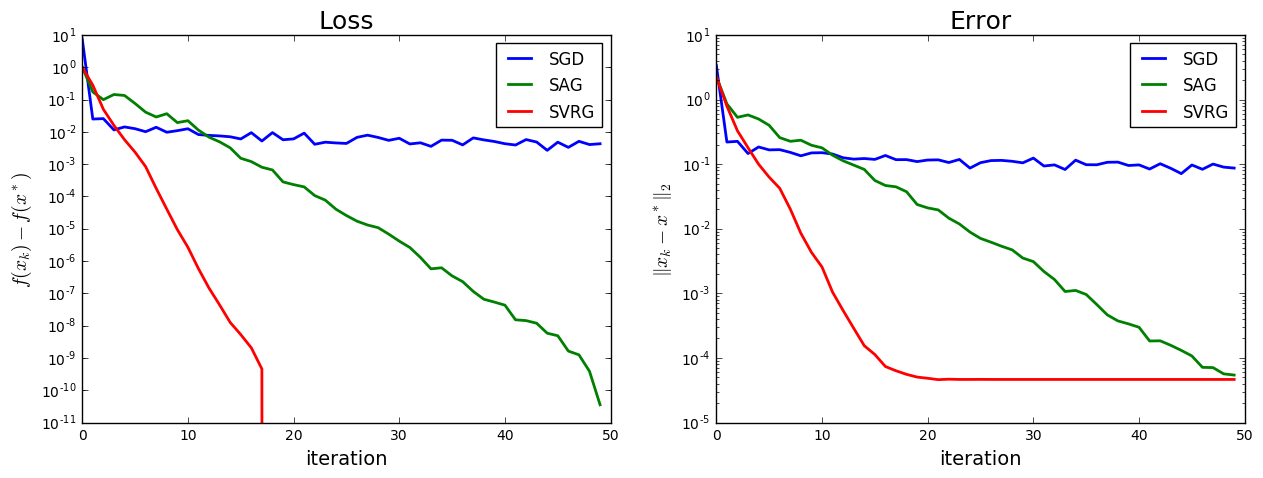

In [124]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Error", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);

<a id='comp'></a> 
## 5. Numerical comparison

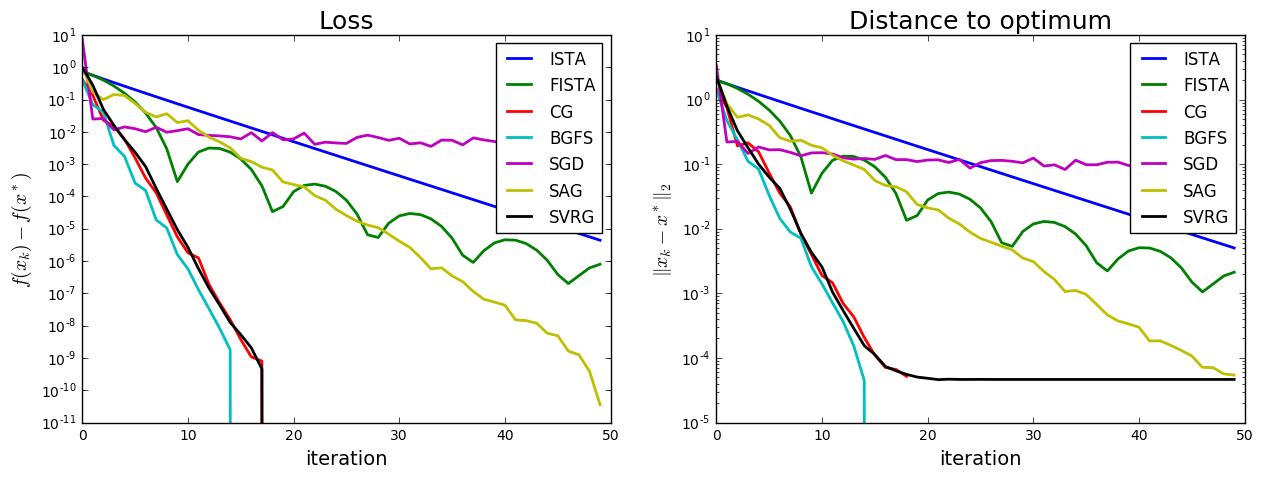

In [125]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector,
              sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["ISTA", "FISTA", "CG", "BGFS", "SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude

- We observe that the SGD algorithm is the best for the 3 first iterations. After that, it becomes progressively the worst of all algorithms. Moreover, the 3 stochastic algorithms (SGD, SAG and SVRG) do not converge to the most precise solution (compared to the others). SAG becomes better than ISTA, FISTA and SGD after 30 iterations. SVRG is similar to BFGS in terms of rate of convergence, but as we said it stops at a certain threshold, whereas BFGS can attain a more precise minimum.

In the following cell, we plot the numerical comparison when setting $\lambda = \frac{1}{n}$ for a linear regression model.
## Please do not run the following cell!

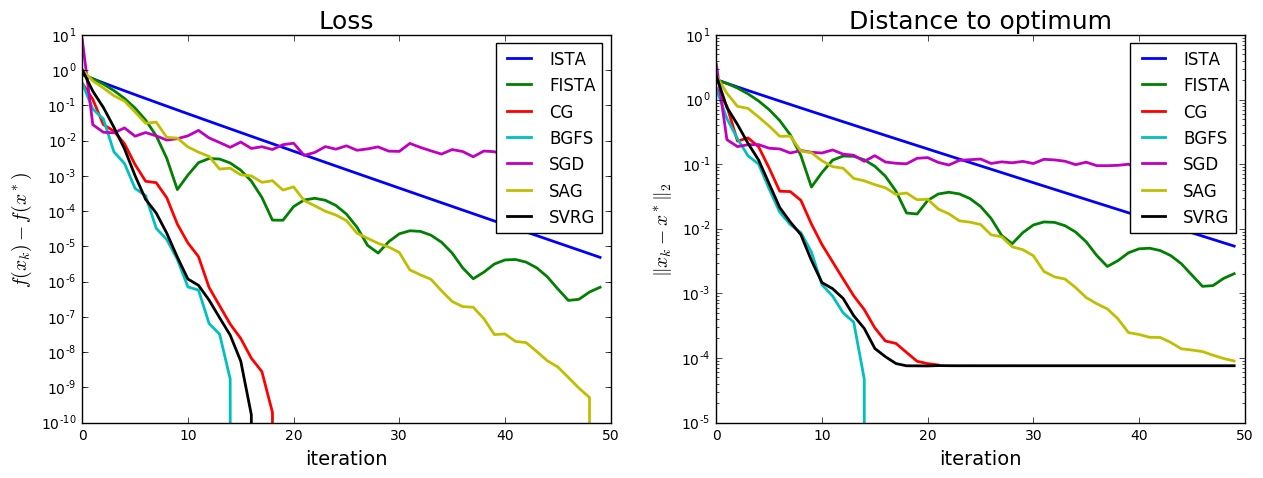

In [35]:
from IPython.core.display import Image
Image("C:/Users/Peter martigny/Desktop/Cours/lambdalow.png")

We observe no real significant change when taking a low ridge.
However, we note that the plateau for SVRG in Distance to optimum plot is higher than the one for high ridge. On the contrary, looking at the Loss plot, we note that SAG converges faster to the optimum.
We notice a slight improvement for BFGS (a few iterations better).

Let us plot the result for $corr = 0.8$ with linear regression.
## Please do not run this cell!

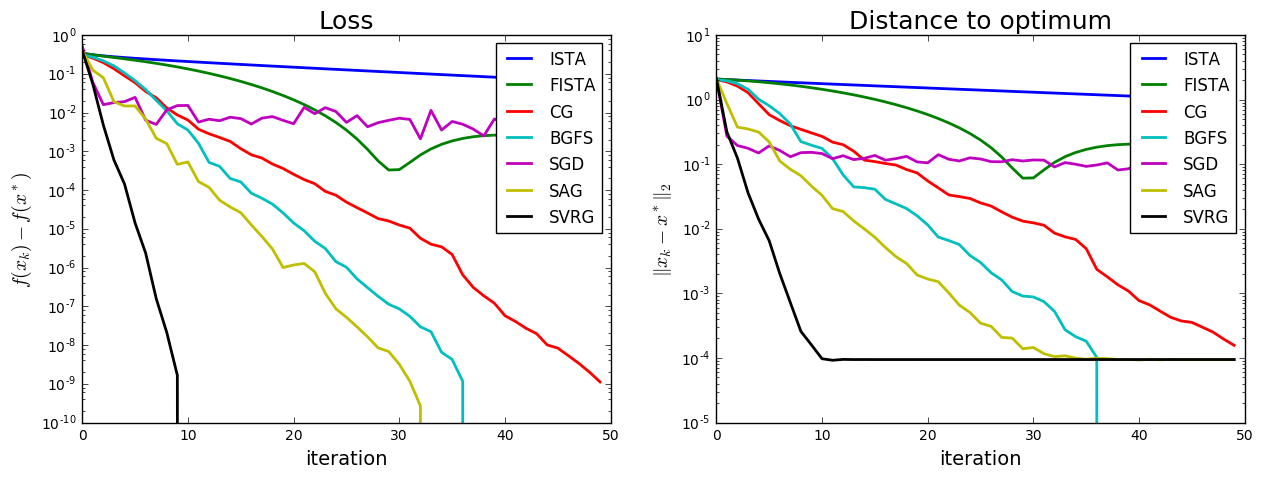

In [58]:
Image("C:/Users/Peter martigny/Desktop/Cours/highcorr.png")

Let us plot the result for $corr = 0.2$ with linear regression.
## Please do not run this cell!

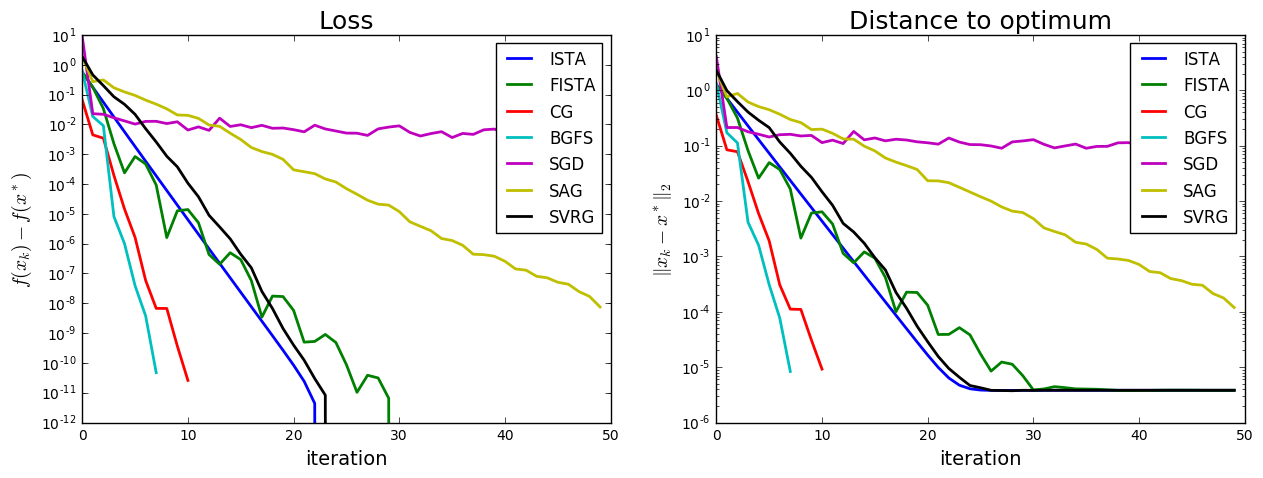

In [81]:
Image("C:/Users/Peter martigny/Desktop/Cours/lowcorr.png")

We observe that for high correlations, ISTA and FISTA converge very slowly, whereas they converge way faster with low correlations.

We notice that CG & BFGS have an opposite behavior compared to ISTA & FISTA.

SAG and SVRG converge faster for high correlations. SGD seems not to be affected by the correlation.

We notice also that, in general, the distance to the optimum is lower for all algorithms except SGD and SAG, in case of  a low correlation.

#### Conclusion

- It is almost always useful to start with SGD for a warm start. However, we need to complete it with another algorithm after a few iterations. 

- Given the correlation of the dataset, we can choose the most suitable optimization algorithm to follow SGD: 

    - SAG or SVRG for high correlations
    - CG or BFGS for low correlations
    
- If we want a super-precise solution for the problem, and are not considering the number of iterations, we can run BFGS or CG, which are always the most precise algorithms (after a certain number of iterations).

- It is not always relevant to compare the algorithms in terms of number of iterations. Indeed, iterations have different meanings for different algorithms, and therefore have different actual computational times. It would be relevant to compare the algorithms in terms of computational time.